# Introduction

The main goal of this tutorial is to demonstrate how one can use Polara to conduct custom experiments with very specific requirements. Needless to say, it can be useful for reproducing someone's research as well. Below you'll find a particular example based on one of my favorite papers called *"[EIGENREC: generalizing PureSVD for effective and efﬁcient top-N recommendations](https://arxiv.org/abs/1511.06033)"*, which helped me to see standard SVD-based models in a differrent light and even led me to [my own discoveries](https://arxiv.org/abs/1807.10634). Even though it's not necessary for understanding the material below, I strongly recommend to read the original paper as it builds on top of clear ideas and contains a very thorough analysis.

The key take home message from this paper for me personally is that **SVD can be viewed as a particular case of a more general eigendecomposition problem of the scaled similarity matrix**. Based on that insight, the authors of the *EigenRec* model propose several modifications, which involve tuning the scaling factor as well as the similarity measure in order to improve the model's performance.

<div class="alert alert-block alert-info">In this tutorial we are not going to reproduce the full work and will focus only on some of its easy-to-implement parts. Basically, we will alter only the scaling factor to see how it affects the quality of recommendations.</div>

Nevertheless, the tutorial allows to verify validity of the proposed ideas and creates a convenient playground for further exploration.

# Data preparation

## Getting Movielens-1M data

As in the previous tutorials, let's download the Movielens dataset. The task should be already familiar to you. This is one of the datasets used in the paper as well. One could use some other datasets, it wouldn't change anything in later parts of the tutorial. The main requirement is to have it in the form of a Pandas dataframe, similarly to what is returned by the `get_movielens_data` function.

In [1]:
from polara import RecommenderData
from polara import get_movielens_data

In [2]:
data = get_movielens_data() # will automatically download it
                            # alternatively you can specify a path to the local copy as an argument to the function
data.head()

,userid,movieid,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [3]:
data_model = RecommenderData(data, 'userid', 'movieid', 'rating', seed=0)

## Custom experimental setup with item sampling

The *EigenRec* paper follows a specific experimentation setup, mainly based on the settings, proposed in my another favorite paper [Performance of recommender algorithms on top-n recommendation tasks](https://dl.acm.org/citation.cfm?id=1864708.1864721), devoted to the *PureSVD* model itself. For evaluation purposes, the authors sample 1.4% of all available ratings and additionally shrink the resulting sample by leaving 5-star ratings only. Quote from the paper (Section 4.2.1): 
<div class="alert alert-block alert-info">"...we form a probeset $\mathcal{P}$ by randomly sampling 1.4% of the ratings of the dataset, and we use each item $v_j$,rated with 5-star by user $u_i$ in $\mathcal{P}$ to create the test set $\mathcal{T}$..."</div>

This setup can be easily implemented in Polara with the help of `test_ratio` and `holdout_size` parameters of the `RecommendeData` instance. **It requires a two-step preparation procedure.**

**The first step** is to sample data without filtering top-rated items. The following configuration does the thing:

In [4]:
data_model.test_ratio = 0 # do not split dataset into folds, use entire dataset for sampling
data_model.holdout_size = 0.014 # sample this fraction of ratings from data
data_model.random_holdout = True # sample ratings randomly (not just 5-star)
data_model.warm_start = False # allow test users to be part of the training (excluding holdout items)

data_model.prepare() # perform sampling

Preparing data...
2 unique movieid's within 2 holdout interactions were filtered. Reason: not in the training data.
Done.
There are 986206 events in the training and 14001 events in the holdout.


Mind the `test_ratio` parameter setting. Together with the `test_fold` parameter it controls, which fraction of the dataset to sample from; 0 means the whole dataset and turns off data splitting mechanism used by Polara for cross-validation. The value of `test_fold` has no effect in that case. Also note that by default Polara performs some additional manipulations with data like cleaning and reindexing to transform it into a uniform internal representation for further use. Key actions and their results are reported in an output text, which can be turned off by setting `data_model.verbose = False`. Here's how to see the final result of sampling:

In [5]:
data_model.test.holdout.head()

,userid,movieid,rating
19,0,2590,4
14,0,969,5
133,1,92,2
61,1,1030,3
231,2,1058,5


**The second step** is to leave only items with rating 5, as it was done in the original paper. The easiest way in our case would be to simply run:
```python
data_model.test.holdout.query('rating==5', inplace=True)
```
However, in general, you shouldn't manually change the data after it was processed by Polara, as it may break some internal logic. A more appropriate and a safier way to achieve the same is to use the `set_test_data` method, specifically designed to cover custom configurations: 

In [6]:
data_model.set_test_data(holdout=data_model.test.holdout.query('rating==5'), # select only 5-star ratings
                         warm_start=data_model.warm_start,                         
                         reindex=False, # avoid reindexing users and items second time
                         ensure_consistency=False # do not try to filter out unseen entities (they are already excluded)
                                                  # leaving it as True wouldn't change the result but would lead to extra checks
                        )

Note that we reuse the previously sampled holdout dataset (the $\mathcal{P}$ dataset in the authors' notation), which is already reindexed by Polara's built-in data pre-processing procedure. In order not to loose the index mapping between internal and external representation of movies and users (stored in the `data_model.index` attribute) it's very important to set `reindex` argument of the `set_test_data` method  to `False`. Now the `data_model.test.holdout` dataframe stores the final result, namely the $\mathcal{T}$ dataset:

In [7]:
data_model.test.holdout.head()

,userid,movieid,rating
14,0,969,5
231,2,1058,5
326,4,2372,5
488,5,3301,5
931,9,1198,5


# Scaled SVD-based model

In the simplest case of the EigenRec model, when only the scaling factor is changed, we can go with a very straightforward approach. Instead of computing similarity matrices and solving an eigendecomposition problem, it is sufficient to apply standard SVD to a scaled rating matrix $\tilde R$:  

$$
\tilde R = R \, S^{d-1} \approx U\Sigma V^T,
$$  

where $R$ is an $M \times N$ rating matrix, $S = \text{diag}\{\|r_1\|_2, \dots, \|r_N\|_2\}^d$ is a diagonal scaling matrix with its non-zero values depending on a scaling parameter $d$ and $r_i$ denotes an $i$-th column of $R$. Note that due to the orthogonality of columns in the SVD factors the approximation of $\tilde R$ can be written in an equivalent and more convenient form $\tilde RVV^T$, which can be used to generate recommendations.

## Scaling input data

In order to calculate the scaled version of the *PureSVD* approach we can reuse the `SVDModel` class implemented in Polara. One of the ways to do that is to redefine the `build` method in an `SVDModel`'s subclass. A simpler solution, however, is to directly modify an output of the `get_training_matrix` method, which is generally available for all models in Polara and is used internally in the `SVDModel` in particular. This method returns the rating matrix in a sparse format, which is then fed into the `scipy`'s truncated SVD implementation within the `build` method (you can run the `SVDModel.build??` command with double question mark to see it). Assuming we already have sparse rating matrix, the following function will help to scale it:

In [8]:
from scipy.sparse import diags
from scipy.sparse.linalg import norm as spnorm

def sparse_normalize(matrix, scaling, axis):
    '''Function to scale either rows or columns of the sparse rating matrix'''
    if scaling == 1: # no scaling (standard SVD case)
        return matrix
    
    norm = spnorm(matrix, axis=axis, ord=2) # compute Euclidean norm of rows or columns
    scaling_matrix = diags(np.power(norm, scaling-1, where=norm!=0))
    
    if axis == 0: # scale columns
        return matrix.dot(scaling_matrix)
    if axis == 1: # scale rows
        return scaling_matrix.dot(matrix)

## Sampling random items for evaluation

Somewhat more involved modifications are required to generate model predictions, as it's based on an additional sampling of items not previously seen by the test users. Quote from the paper (Section 4.2.1): 
<div class="alert alert-block alert-info">"For each item in $\mathcal{T}$, we randomly select another 1000 unrated items of the same user..."</div>

This means that we need to generate prediction scores for 1000 randomly selected unseen items in addition to every item from the holdout. Moreover, **every set of 1001 items is treated independently of the user it belongs to**. Normally, Polara performs evaluation on a *per user basis*; however, in this case the logic is different and we have to take care of users with mulltiple items in the holdout. From the line below it can be clearly seen that some test users can have up to 8 items:

In [9]:
data_model.test.holdout.userid.value_counts().max()

8

In order to "flatten" the holdout dataset and to independently generate prediction scores for every holdout item (and 1000 of additionally sampled items) we will customize the `get_recommendations` method of the `SVDModel` class. Below is the support function, that helps to achieve the necessary result. It iterates over all holdout items, randomly samples a predefined amount of previously unrated items and generates prediction scores for them:

In [10]:
def sample_scores_flat(useridx, itemidx, seen_data, all_items, user_factors, item_factors, sample_size=1000, random_state=None):
    '''Function to randomly sample unrated items and generate prediction scores for them.'''
    scores = []
    for user, items in itemidx.groupby(useridx): # iterate over every test user and get all user items
        seen_items = seen_data[1][seen_data[0]==user].tolist() # list of the previously rated items of the user
        seen_items.extend(items.tolist()) # take holdout items into account as well
        item_pool = all_items[~all_items.isin(seen_items)] # exclude seen items from all available items
        for item in items:
            sampled_items = item_pool.sample(n=sample_size, random_state=random_state) 
            scores.append(item_factors[sampled_items.values, :].dot(user_factors[user, :]))
    return scores


<div class="alert alert-block alert-warning">Prediction scores are generated similarly to the standard *PureSVD* model by an orthogonal projection of a vector $r$ of user ratings onto the latent feature space, defined by the formula $VV^Tr$. Note that unlike the model computation phase, no scaling is used in the prediction.</div>

The code above complies with this definition by expecting `user_factors` to be the product $V^Tr$ for a set of test users and `item_factors` to be $V$ itself. Below you can find a full implementation of our new model.

## Defining the model

In [11]:
import numpy as np
import pandas as pd
from polara import SVDModel

class ScaledSVD(SVDModel):
    '''Class that adds scaling functionality to the PureSVD model'''
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.col_scaling = 1 # scaling parameted d, initially corresponds to PureSVD
        self.n_rnd_items = 1000 # number of randomly sampled items
        self.seed = 0 # to control randomization
        self.method = 'ScaledSVD'
        
    def get_training_matrix(self, *args, **kwargs):
        svd_matrix = super().get_training_matrix(*args, **kwargs) # get sparse rating matrix
        return sparse_normalize(svd_matrix, self.col_scaling, 0)
        
    def get_recommendations(self):
        holdout = self.data.test.holdout
        itemid = self.data.fields.itemid # "movieid" in the case of Movielense dataset
        userid = self.data.fields.userid # "userid" in the case of Movielense dataset
        
        itemidx = holdout[itemid] # holdout items of the test users
        useridx = pd.factorize(holdout[userid])[0] # have to "rebase" user index;
                                                   # necessary for indexing rows of the matrix with test user ratings
        
        # prediction scores for holdout items
        test_matrix, seen_data = self.get_test_matrix()    
        item_factors = self.factors[itemid] # right singular vectors, matrix V
        user_factors = test_matrix.dot(item_factors) # according to product V^T r for every test user
        holdout_scores = (user_factors[useridx, :] * item_factors[itemidx.values, :]).sum(axis=1).squeeze()
        
        # scores for randomly sampled unseen items
        all_items = self.data.index.itemid.new # all unique (reindexed) items
        rs = np.random.RandomState(self.seed) # fixing random state to control random output
        sampled_scores = sample_scores_flat(useridx, itemidx,
                                            seen_data, all_items,
                                            user_factors, item_factors,
                                            self.n_rnd_items, random_state=rs)
        
        # combine all scores and rank selected items             
        scores = np.concatenate((holdout_scores[:, None], sampled_scores), axis=1) # stack into array with 1001 columns
        rankings = np.apply_along_axis(np.argsort, 1, -scores)
        return rankings

The model is ready and can be used in a standard way:

In [12]:
svd = ScaledSVD(data_model) # create model
svd.rank = 50
svd.col_scaling = 0.5
svd.build() # fit model

ScaledSVD training time: 0.534s


Now, when we have our model computed, its time to evaluate it. However, **we cannot use the built-in evaluation routine**. Normally, the number of test users is equal to the number of rows in recommendations array and that's the logic Polara relies on. In our case the number of test users is lower than the number of rows in recommendations array and actually corresponds to the total number of ratings in the holdout:

In [13]:
# if you run the cell for the first time you'll notice a short delay before print output due to calculation of recommendations
print('# of test users:', data_model.test.holdout.userid.nunique())
print('# of rows and columns in recommendations array:', svd.recommendations.shape)
print('# of ratinhgs in the holdout:', data_model.test.holdout.shape[0])

# of test users: 2009
# of rows and columns in recommendations array: (3140, 1001)
# of ratinhgs in the holdout: 3140


We will fix this inconsistency in the next section.

Worth noting here that Polara implements a unified system of callbacks, which reset the `svd.recommendations` property whenever either the `data_model` or the model itself are changed in a way that affects the models' output (try, for example, call `svd.recommendations`, then set the rank of the model to some higher value and call `svd.recommendations` again). This mechanism helps to ensure predictable and consistent state and to prevent accidental reuse of the cached results during experiments. 
It can also be extended with user-defined triggers, which is probably the topic for another tutorial.

## Model evaluation

### Simple approach

When you try to evaluate your model, it calls for the `model.recommendations` property which is automatically filled with the result of the `get_recommendations` method. The simplest way to evaluate the result in accordance with the new structure of the recommendations array is to define a small function as shown below:

In [14]:
def evaluate_mrr(model):
    '''Function to calculate MRR score.'''
    is_holdout = model.recommendations==0 # holdout items are always in the first column before sorting
    pos = np.where(is_holdout)[1] + 1.0 # position of holdout items (indexing starts from 0, so adding 1) 
    mrr = np.reciprocal(pos).mean() # mean reciprocal rank
    return mrr

Finally, to compute the MRR score, as it is done in the original paper, simply run:

In [15]:
evaluate_mrr(svd)

0.3130822345824591

### More functional approach

While the previously described approach is fully working and easy, in some cases you may want to use the built-in `model.evaluate` method, as it provides additional functionality. It is also useful to see how Polara can be customized to serve specific needs. The key ingredient here is the control of the type of entities that are recommended. By default, Polara expects items to be recommended to users and looks for the corresponding fields in the test data. These fields are defined via `data_model.fields.userid` and `data_model.fields.itemid` attributes respectively. The default behavior, however, can be redefined at the model level be setting `model._prediction_key` (users by default) and `model._prediction_target` (items by default) attributes to custom values. This scheme, for example, can be utilized in cold start experiments, where the task is to find users potentially interested in a "cold" item instead of recommending items to users (see `polara.recommender.coldstart` for implementation details). The following lines show how to change the default settings for our needs:

In [16]:
svd._prediction_key = 'xuser'
svd._prediction_target = 'xitem'

Now, we need to specify the corresponding fields in the holdout data. Recall that our goal is to treat every item in the holdout independently of the user or, in other words, to assign every item to a unique "virtual" user (`'xuser'`). Furthermore, by construction, prediction scores for holdout items are located in the first column of the recommendations array. This means that every holdout item (`'xitem'`) should have index 0. Here's the necessary modification:

In [17]:
data_model.test.holdout['xuser'] = np.arange(data_model.test.holdout.shape[0]) # number of rated items defines the range
data_model.test.holdout['xitem'] = 0

Let's check that the result is the same (up to a small rounding error due to different calculation schemes):

In [18]:
svd.evaluate('ranking', simple_rates=True) # `simple_rates` is used to enforce calculation of MRR

Ranking(mrr=0.31308223458245904)

<div class="alert alert-block alert-warning">If you'll do the math you'll see that the whole experiment took under 100 lines of code to program, and the most part of it was pretty standard (i.e., declaring variables and methods).</div>

Less lines of code typically means less risks for having bugs or inconsistencies. By following a certain protocol, Polara provides a high-level interface that abstracts many technical aspects allowing to focus on the most important parts of research.

# Reproducing the results

The next task is to repeat experiments from the EigenRec paper, where the authors compute
<div class="alert alert-block alert-info">"...MRR scores as a function of the parameter $d$ for every case, using the number of latent factors that produces the best possible performance for each matrix."</div>

## Grid search

The beauty of SVD-based models is that it is much easier to perform grid-search for finding optimal values of hyper-parameters. Once you have computed a model for a certain set of hyper parameters with some rank value $k$, you can quickly find all other models of rank "k' < k" without recomputing SVD.
<div class="alert alert-block alert-info">Going from larger values of rank to smaller ones is performed by a simple truncation of the latent factor matrix.</div>

This not only allows to perform experiments faster, but also simplifies the code for it. Moreover, `SVDModel` already has the necessary rank-check procedures, which allow to avoid rebuilding the model when user sets a smaller value of rank. No special actions are required here. Below is the code that implements the grid search experiment, taking that feature into account (note that on a moderate hardware the code will run for approximately half an hour):

In [20]:
try:
    from ipypb import track
except ImportError:
    from tqdm import tqdm_notebook as track
%matplotlib inline

svd_mrr_flat = {} # will stor results here
svd.verbose = False

max_rank = 150
scaling_params = np.arange(-20, 21, 2) / 10 # values of d from -2 to 2 with step 0.2
svd_ranks = range(10, max_rank+1, 10) # ranks from 10 to max_ranks with step 10

for scaling in track(scaling_params):
    svd.col_scaling = scaling
    svd.rank = max_rank
    svd.build()
    
    for rank in list(reversed(svd_ranks)): # iterating over rank values in a descending order
        svd.rank = rank                    # allows to truncate factor matrices without recomputing SVD
        svd_mrr_flat[(scaling, rank)] = svd.evaluate('ranking', simple_rates=True).mrr

 [████████████████████████████████████████████████████████████] 21/21 [37:36<01:44, 107.45s/it]

## Results

Now we have the results of the grid search stored in the `svd_mrr_flat` dictionary. There's one catch that wasn't clear for me at first:
<div class="alert alert-block alert-warning">in order to show the effect of parameter $d$ the authors have fixed the value of rank corresponding to the best result achieved with EigenRec.</div>

This means that the curve on Figure 1 in the original paper is obtained with a fixed value of rank, corresponding to the optimal point at the top of the curve, and all other points are obtained by only changing the scaling factor. Here's one way to draw it:

In [21]:
result_flat = pd.Series(svd_mrr_flat)
best_d, best_rank = result_flat.idxmax()
best_d, best_rank

(0.4, 120)

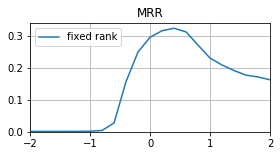

In [22]:
result_flat.xs(best_rank, axis=0, level=1).plot(label='fixed rank', legend=True, title='MRR',
                                                figsize=(4.3, 2), ylim=(0, None), xlim=(-2, 2), grid=True);

Comparing this picture to the bottom left graph of Figure 1 in the original paper leads to a satisfactory conclusion that the curves on the graphs are very close. Of course, there are slight differences; however, there are many factors that may affect it, like data sampling and unrated items randomization. It would be a good idea to repeat the experiment with different `seed` values and draw a confidence region around the curve. However, there are no drammatic differences in the general behavior of the curves, which is a very nice result that didn't take too much efforts. Here are some top-score configurations from the experiment:

In [23]:
result_flat.sort_values(ascending=False).head()

0.4  120    0.323893
     110    0.322767
     140    0.321977
0.6  60     0.321719
0.4  130    0.321421
dtype: float64

## A bit of exploration

The difference between the best result achieved with the EigenRec approach and the standard PureSVD result (that corresponds to the point with scaling parameter equal to 1) is quite large. However, such a comparison is a bit unfair as the restriction on having a fixed value of rank is artificial. We can draw another curve that corresponds to optimal values of both scaling parameter and rank of the decomposition:

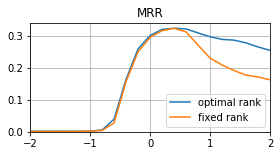

In [24]:
result_flat.groupby(level=0).max().plot(label='optimal rank', legend=True)
result_flat.xs(best_rank, axis=0, level=1).plot(label='fixed rank', legend=True, title='MRR',
                                                figsize=(4.3, 2), ylim=(0, None), xlim=(-2, 2), grid=True);

Now the difference is less pronounced. Anyway, the EigenRec approach still performs better. Moreover, the difference vary significantly from dataset to dataset and in some cases that difference can be much more noticeable. Another degree of freedom here, which may increase the top score, is the maximum value of rank used in the grid search. We have manually set it to be 150. Let's look which values of rank were used at each point of the curve:

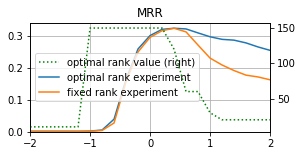

In [25]:
ax = result_flat.groupby(level=0).idxmax().str[1].plot(label='optimal rank value', ls=":", legend=True,
                                                       secondary_y=True, c='g')
result_flat.groupby(level=0).max().plot(label='optimal rank experiment', legend=True)
result_flat.xs(best_rank, axis=0, level=1).plot(label='fixed rank experiment', legend=True, title='MRR',
                                                figsize=(4.3, 2), ylim=(0, None), xlim=(-2, 2), grid=True);

Clearly, the values are capped on the left half of the graph, which leaves the room for further improvement. I have performed experiments with a higher threshold and was able to achieve a higher top score with a bit lower value of the scaling parameter. If you want to see this, simply rerun the grid search experiment with a higher value of the `max_rank` variable. Be prepared that it will take a longer time (hint: reduce the search space for the scaling parameter). Anyway, the key conclusion doesn't change - **even a simple scaling factor can be advantageous and allows to outperform the standard model**. This conclusion is supported by many other experiments in the original paper, which we haven't run here.

### Bonus: Double-scaled SVD

 The main change in the model is basically enclosed in the following line
```python
scaled_matrix = sparse_normalize(svd_matrix, self.col_scaling, 0)
```
which scales columns of the rating matrix. However, there's nothing really special about this particular type of scaling and we could also scale rows instead of or in addition to that. Scaling rows would help to control the contribution of users with either too high or too low number of rated items. The entire code for defining the double-scaled model is listed below:

```python
class DScaledSVD(ScaledSVD):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.row_scaling = 1 # PureSVD config
        self.method = 'DScaledSVD'
        
    def get_training_matrix(self, *args, **kwargs):
        svd_matrix = super().get_training_matrix(*args, **kwargs)
        return sparse_normalize(svd_matrix, self.row_scaling, 1)
```

Note that running the grid search experiment with two scaling parameters, `row_scaling` and `col_scaling`, will take more time. In my experiments with Movielense data and the value of rank limited by 150 from the above there was a very weak improvement, which wasn't worth the efforts. This however, may change with higher values of ranks or at least with another data. I'll leave verifying this for the reader.

# Instead of conclusion

Being a researcher myself, I'm often involved in some sort of "redoing" the work that was already done by someone else. Leaving the reproducibility aspect aside, there are many other reasons why it can be useful, e.g., it may help to understand presented ideas better or to see if there're any subtle moments in an original work that are not evident at first glance. It helps to create a playground ready for further exploration and may even lead to new ideas. I hope that Polara will help you with this as it helps me in my own research.